In [50]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
import pandas as pd
import sklearn
import numpy as np
import glob
from mountaineer import Mountaineer
from gale import create_mapper

## Import Diabetes dataset

In [51]:
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv("./dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [52]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

## Train a neural network model with two hidden layers

In [99]:
batch_size = 16
num_epochs = 80
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [101]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [102]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.35929 | Acc: 84.846 | F1: 75.71441
Epoch 040: | Loss: 0.25629 | Acc: 89.846 | F1: 84.90492
Epoch 060: | Loss: 0.19892 | Acc: 92.423 | F1: 88.43080
Epoch 080: | Loss: 0.18990 | Acc: 92.423 | F1: 89.01253
Set to eval


In [103]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()

X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (144, 8)
Y_test of correct predictions shape: (144,)
Label in Y_test of correct predictions ratio: 
 [[  0 114]
 [  1  30]]


## Use the sigmoid function as the prediction probability function for Mapper

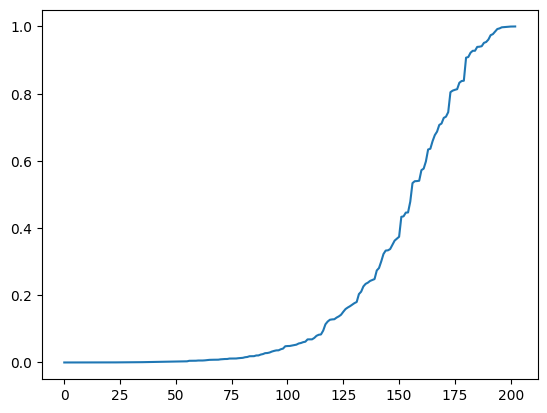

In [104]:
predictions = torch.sigmoid(model(X_test_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [105]:
print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [106]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]
    #for exp in explanations[method]:
        #exp[exp>5]=5
        #exp[exp<-5]=-5

Start integrated gradients for correct predictions with black_baseline
--- '0.31' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '0.90' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '2.33' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '2.33' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '2.33' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.20' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.33' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '1.99' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '2.01' seconds computation time ---
Start DeepSHAP for correct predic

In [107]:
#baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']

## Creating the mapper outputs

In [108]:
import sklearn
mapper1 = create_mapper(explanations['IG'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper2 = create_mapper(explanations['IG'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper3 = create_mapper(explanations['IG'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper4 = create_mapper(explanations['IG'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper5 = create_mapper(explanations['IG'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))

mapper6 = create_mapper(explanations['DeepSHAP'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper7 = create_mapper(explanations['DeepSHAP'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper8 = create_mapper(explanations['DeepSHAP'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper9 = create_mapper(explanations['DeepSHAP'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper10 = create_mapper(explanations['DeepSHAP'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))


mapper11 = create_mapper(explanations['DeepLIFT'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper12 = create_mapper(explanations['DeepLIFT'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper13 = create_mapper(explanations['DeepLIFT'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper14 = create_mapper(explanations['DeepLIFT'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))
mapper15 = create_mapper(explanations['DeepLIFT'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.3, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=42))


In [109]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:1920px !important; }</style>"))

In [110]:
#visualize
test = Mountaineer()
#list of mapper outputs - minimum 2
mapper_outputs=[mapper1, mapper2, mapper3, mapper4, mapper5, mapper6, mapper7, mapper8, mapper9, mapper10, mapper11, mapper12, mapper13, mapper14, mapper15]

explanation_vectors=[explanations['IG'][0],explanations['IG'][1],explanations['IG'][2],explanations['IG'][3],explanations['IG'][4],  explanations['DeepSHAP'][0], explanations['DeepSHAP'][1], explanations['DeepSHAP'][2], explanations['DeepSHAP'][3], explanations['DeepSHAP'][4], explanations['DeepLIFT'][0], explanations['DeepLIFT'][1], explanations['DeepLIFT'][2], explanations['DeepLIFT'][3], explanations['DeepLIFT'][4]]
explanation_list=[]
for expl in explanation_vectors:
    explanation_list.append(expl.tolist())
    

#array of what we want the values to be colored by by default(In this case we are simply passing the lens - ie. Prediction Probabilities)
color_values = [np.array([np.squeeze(i) for i in predictions])]
#column names of the dataframe
column_names= np.array(X.columns)
test.visualize(X_test.to_numpy(),y_test.to_numpy(), mapper_outputs, color_values, explanation_list, column_names, 'UMAP') #Projection method- 'UMAP' or 'TSNE'

In [94]:
#mean of explanation attributions for every feature zero baseline Integrated Gradient
np.max(explanation_vectors[0], axis=0)

array([ 2635.75917794, 48572.98782677,   101.58229647, 15892.44835335,
         303.73950533,  4098.755933  ,   251.57819381, 69362.17805899])

In [95]:
#means of explanation attributions for every feature for max distance baseline Integrated Gradients
np.mean(explanation_vectors[1], axis=0)

array([ -575.25376661, -4160.34318524,  7942.50137515,  3016.74541424,
        4819.00667897,  7171.19036491,  -218.09268543,  6699.80678675])

In [96]:
#mean of explanation attributions for every feature zero baseline Integrated Gradient
np.median(explanation_vectors[0], axis=0)

array([ 0.40655741, 45.47753405, 29.12844517,  1.76871987,  0.        ,
       16.91236175,  1.26735429,  6.16778365])

In [97]:
np.min(explanation_vectors[0], axis=0)

array([-9.07668412e+02, -2.10979306e+04, -2.40258190e+04, -1.17213384e+01,
       -1.71298928e+01, -1.20318857e+04, -8.77207959e+02, -3.81966170e+04])

In [98]:
X_test.describe()

,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,4.019704,119.832512,68.857143,21.024631,84.177340,31.002956,0.451823,34.802956
std,3.422350,32.489473,20.245383,15.851551,121.087719,8.567547,0.279240,12.898714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,26.800000,0.255000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,48.000000,31.200000,0.361000,31.000000
75%,6.000000,138.000000,80.000000,32.000000,131.000000,36.000000,0.629500,42.500000
max,17.000000,196.000000,104.000000,54.000000,846.000000,49.700000,1.731000,81.000000
